# Preamble

In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_long/code/func/')
from proj_environment import set_proj_env
from func import get_cmap

In [3]:
exclude_str = 't1Exclude'
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str)

### Setup output directory

In [4]:
print(os.environ['MODELDIR'])
if not os.path.exists(os.environ['MODELDIR']): os.makedirs(os.environ['MODELDIR'])

/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_long/analysis/normative/t1Exclude/schaefer_400


# Load in metadata

In [5]:
# Protocol
prot = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n2416_dataFreeze/neuroimaging/n2416_pnc_protocol_validation_params_status_20170103.csv'))
# T1 QA
t1_qa = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n2416_dataFreeze/neuroimaging/t1struct/n2416_t1QaData_20170516.csv'))
# DTI QA
dti_qa = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n2416_dataFreeze/neuroimaging/dti/n2416_DTI64/n2416_dti_qa_20170301.csv'))
# REST QA
rest_qa = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n2416_dataFreeze/neuroimaging/rest/n2416_RestQAData_20170714.csv'))
# Demographics
demog = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n2416_dataFreeze/clinical/n2416_demographics_20170310.csv'))
# Brain volume
brain_vol = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n2416_dataFreeze/neuroimaging/t1struct/n2416_antsCtVol_20170412.csv'))
# incidental findings
inc_find = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n9498_dataFreeze/health/n9498_health_20170405.csv'))

# GOASSESS Bifactor scores
goassess = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'GO_Longitudinal_clinical_factor_scores_psychosis_split_BIFACTOR.csv'))
goassess.set_index(['bblid'], inplace = True)

# merge
df = prot
df = pd.merge(df, t1_qa, on=['scanid', 'bblid']) # t1_qa
df = pd.merge(df, dti_qa, on=['scanid', 'bblid']) # dti_qa
df = pd.merge(df, rest_qa, on=['scanid', 'bblid']) # rest_qa
df = pd.merge(df, demog, on=['scanid', 'bblid']) # demog
df = pd.merge(df, brain_vol, on=['scanid', 'bblid']) # brain_vol

print(df.shape[0])
df.set_index(['bblid', 'scanid'], inplace = True)
df = df.sort_index(axis = 0, level = 0)

2416


In [6]:
df['scanageYears'] = np.round(df.scanageMonths/12, decimals=1)

In [7]:
df_tmp = pd.merge(df, inc_find, on=['bblid']) # goassess

In [8]:
df.loc[:,'incidentalFindingExclude'] = df_tmp.loc[:,'incidentalFindingExclude'].copy().values

# Filter subjects

Filter out subjects using the QA procedures generated by BBL.

In [9]:
# 0) incidental findings
df = df[df['incidentalFindingExclude'] == 0]
print('N after incidentalFindingExclude:', df.shape[0])

# 2) T1 exclusion
df = df[df[exclude_str] == 0]
df = df[df['t1PostProcessExclude'] == 0]
print('N after T1 exclusion:', df.shape[0])

N after incidentalFindingExclude: 2390
N after T1 exclusion: 2315


## Load in data

In [10]:
metrics = ('ct', 'vol')

In [11]:
# output dataframe
ct_labels = ['ct_' + str(i) for i in range(num_parcels)]
vol_labels = ['vol_' + str(i) for i in range(num_parcels)]

df_node = pd.DataFrame(index = df.index, columns = ct_labels + vol_labels)

print(df_node.shape)

(2315, 800)


### Thickness

In [12]:
# subject filter
subj_filt = np.zeros((df.shape[0],)).astype(bool)

In [13]:
CT = np.zeros((df.shape[0], num_parcels))

for (i, (index, row)) in enumerate(df.iterrows()):
    file_name = os.environ['CT_NAME_TMP'].replace("bblid", str(index[0]))
    file_name = file_name.replace("scanid", str(index[1]))
    full_path = glob.glob(os.path.join(os.environ['CTDIR'], file_name))
    if i == 0: print(full_path)
        
    if len(full_path) > 0:
        ct = np.loadtxt(full_path[0])
        CT[i,:] = ct
    elif len(full_path) == 0:
        subj_filt[i] = True
    
df_node.loc[:,ct_labels] = CT

['/Volumes/ResProjects_2TB/ResData/PNC/processedData/antsCorticalThickness/80010/20100218x2894/ct_schaefer400_17.txt']


In [14]:
np.sum(subj_filt)

0

In [15]:
if any(subj_filt):
    df = df.loc[~subj_filt]
    df_node = df_node.loc[~subj_filt]

In [16]:
print('N after excluding missing subjects:', df.shape[0])

N after excluding missing subjects: 2315


### Volume

In [17]:
# subject filter
subj_filt = np.zeros((df.shape[0],)).astype(bool)

In [18]:
VOL = np.zeros((df.shape[0], num_parcels))

for (i, (index, row)) in enumerate(df.iterrows()):
    file_name = os.environ['VOL_NAME_TMP'].replace("bblid", str(index[0]))
    file_name = file_name.replace("scanid", str(index[1]))
    full_path = glob.glob(os.path.join(os.environ['VOLDIR'], file_name))
    if i == 0: print(full_path)    
    
    if len(full_path) > 0:
        img = nib.load(full_path[0])
        v = np.array(img.dataobj)
        v = v[v != 0]
        unique_elements, counts_elements = np.unique(v, return_counts=True)
        if len(unique_elements) == num_parcels:
            VOL[i,:] = counts_elements
        else:
            print(str(index) + '. Warning: not all parcels present')
            subj_filt[i] = True
    elif len(full_path) == 0:
        subj_filt[i] = True
    
df_node.loc[:,vol_labels] = VOL

['/Volumes/ResProjects_2TB/ResData/PNC/processedData/gm_vol_masks_native/80010/20100218x2894/Schaefer2018_400_17Networks_native_gm.nii.gz']
(80265, 3145). Warning: not all parcels present
(87548, 3139). Warning: not all parcels present


In [19]:
np.sum(subj_filt)

2

In [20]:
if any(subj_filt):
    df = df.loc[~subj_filt]
    df_node = df_node.loc[~subj_filt]

In [21]:
print('N after excluding missing subjects:', df.shape[0])

N after excluding missing subjects: 2313


### Multiple scans

Screen out people who, due to the QA screening above, have non-continuous scans. For example, if an individual's T2 scan doesn't pass QA, but T1 and T3 do.

Also, I retain those participants who have only single timepoints of data even if those timepoints aren't T1.

In [22]:
keep_me = ([1],[2],[3],[1,2],[1,2,3])
idx_keep = []
idx_drop = []
for idx, data in df.groupby('bblid'):
    my_list = list(data['timepoint'].values)
    if my_list == keep_me[0] or my_list == keep_me[1] or my_list == keep_me[2] or my_list == keep_me[3] or my_list == keep_me[4]:
        idx_keep.append(idx)
    else:
        idx_drop.append(idx)

In [23]:
df = df.loc[idx_keep,:]
df_node = df_node.loc[idx_keep,:]

In [24]:
print('N after exclusion non-continuous scans:', df.shape[0])

N after exclusion non-continuous scans: 2305


### Create new total time points column

The above filtering steps creates a mismatch between the number of timepoints each participant has according to BBL recruitment and how many I retain for analysis.

I create a new variable that counts the number of timpeoints each participant has after my filtering.

In [25]:
for idx, data in df.groupby('bblid'):
    df.loc[idx,'TotalNtimepoints_new'] = int(data.shape[0])
df.loc[:,'TotalNtimepoints_new'] = df.loc[:,'TotalNtimepoints_new'].astype(int)

In [26]:
print('N w/ 1 timepoint:', df.loc[df['TotalNtimepoints_new'] == 1,:].shape[0])
print('N w/ >=2 timepoints:', int(df.loc[df['TotalNtimepoints_new'] == 2,:].shape[0]/2 + df.loc[df['TotalNtimepoints_new'] == 3,:].shape[0]/3))
print('N w/ 3 timepoints:', int(df.loc[df['TotalNtimepoints_new'] == 3,:].shape[0]/3))

N w/ 1 timepoint: 992
N w/ >=2 timepoints: 567
N w/ 3 timepoints: 179


### Concat clinical data

Note, this will fill missing phenotype data with NaNs. I prioritise retaining the full imaging sample for now.

In [27]:
df.reset_index(inplace = True)
df.set_index(['bblid', 'timepoint'], inplace = True)
goassess.reset_index(inplace = True)
goassess.set_index(['bblid', 'timepoint'], inplace = True)

In [28]:
goassess.loc[:,'scanid'] = np.float('nan')

In [29]:
for idx, data in df.iterrows():
    goassess.loc[idx,'scanid'] = data['scanid']

In [30]:
df_out = pd.merge(df, goassess, on=['bblid', 'scanid', 'timepoint']).reset_index()
df_out.set_index(['bblid', 'scanid', 'timepoint'], inplace = True)

In [31]:
header = ['TotalNtimepoints', 'TotalNtimepoints_new', 'sex', 'race', 'ethnicity', 'scanageMonths', 'scanageYears', 'mprage_antsCT_vol_TBV', 'averageManualRating', 'dti32MeanRelRMS', 
          'Overall_Psychopathology', 'Mania', 'Depression', 'Psychosis_Positive', 'Psychosis_NegativeDisorg',]
df_out = df_out.loc[:,header]

Designate the individuals with only 1 timepoint as 'train' (False) and individuals with longitudinal data as 'test' (True)

In [32]:
df_out.loc[:,'train_test'] = df_out.loc[:,'TotalNtimepoints_new'] != 1

In [33]:
df_out.head()

TotalNtimepoints  TotalNtimepoints_new  sex  race  \
bblid scanid timepoint                                                      
80010 2894   1                         2                     2    1     1   
      7211   2                         2                     2    1     1   
80179 2643   1                         1                     1    2     1   
80199 2637   1                         1                     1    1     5   
80208 3016   1                         1                     1    1     2   

                        ethnicity  scanageMonths  scanageYears  \
bblid scanid timepoint                                           
80010 2894   1                  2            262          21.8   
      7211   2                  2            293          24.4   
80179 2643   1                  2            255          21.2   
80199 2637   1                  1            245          20.4   
80208 3016   1                  2            246          20.5   

                        mprage_antsCT_vol_TBV  averageManualRating  \
bblid scanid timepoint                                               
80010 2894   1                   1.383110e+06                2.000   
      7211   2                   1.412140e+06                2.000   
80179 2643   1                   1.310120e+06                1.667   
80199 2637   1                   1.590630e+06                2.000   
80208 3016   1                   1.397398e+06                2.000   

                        dti32MeanRelRMS  Overall_Psychopathology     Mania  \
bblid scanid timepoint                                                       
80010 2894   1                 0.669736                 0.477260  0.234406   
      7211   2                 0.173847                -0.313878 -0.511101   
80179 2643   1                 0.321203                -0.355627 -0.489316   
80199 2637   1                 0.120190                 1.266311  2.008614   
80208 3016   1                 0.262002                 2.226531 -2.626595   

                        Depression  Psychosis_Positive  \
bblid scanid timepoint                                   
80010 2894   1            0.411101           -0.765745   
      7211   2            2.357006            0.169766   
80179 2643   1           -0.737088           -0.605224   
80199 2637   1            0.968194            0.970645   
80208 3016   1            0.526181           -0.372209   

                        Psychosis_NegativeDisorg  train_test  
bblid scanid timepoint                                        
80010 2894   1                          1.321310        True  
      7211   2                          0.555718        True  
80179 2643   1                          2.726989       False  
80199 2637   1                          1.385857       False  
80208 3016   1                         -1.461359       False

### Final numbers

In [34]:
print('N w/ 1 timepoint:', df_out.loc[df_out['TotalNtimepoints_new'] == 1,:].shape[0])
print('N w/ >=2 timepoints:', int(df_out.loc[df_out['TotalNtimepoints_new'] == 2,:].shape[0]/2 + df_out.loc[df_out['TotalNtimepoints_new'] == 3,:].shape[0]/3))
print('N w/ 3 timepoints:', int(df_out.loc[df_out['TotalNtimepoints_new'] == 3,:].shape[0]/3))

N w/ 1 timepoint: 992
N w/ >=2 timepoints: 567
N w/ 3 timepoints: 179


### Export

In [35]:
if np.all(df_out.index.get_level_values(0) == df_node.index.get_level_values(0)) and np.all(df_out.index.get_level_values(1) == df_node.index.get_level_values(1)):
    df_node.index = df_out.index

In [36]:
df_out.to_csv(os.path.join(os.environ['MODELDIR'], 'df_pheno.csv'))
df_node.to_csv(os.path.join(os.environ['MODELDIR'], 'df_node_base.csv'))

In [37]:
# find unique ages
age_unique = np.unique(df_out['scanageYears'])
print('There are', age_unique.shape[0], 'unique age points')

# Check if train and test represent the full unique age space
train_diff = np.setdiff1d(df_out.loc[~df_out.loc[:,'train_test'],'scanageYears'],age_unique)
test_diff = np.setdiff1d(df_out.loc[df_out.loc[:,'train_test'],'scanageYears'],age_unique)

if train_diff.size == 0:
    print('All unique age points are represented in the training set')
elif train_diff.size != 0:
    print('All unique age points ARE NOT represented in the training set')
    
if test_diff.size == 0:
    print('All unique age points are represented in the testing set')
elif test_diff.size != 0:
    print('All unique age points ARE NOT represented in the testing set')

There are 180 unique age points
All unique age points are represented in the training set
All unique age points are represented in the testing set


# Plots

In [38]:
labels = ['Train', 'Test']
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = get_cmap('pair')

## Age

In [39]:
df_out.loc[:,'sex'].unique()

array([1, 2])

Predictably the test set has more data in the upper tail of the age distribution. This is because I define the test set based on individuals with multiple time points. This will limit the capacity for the normative model to generate deviations in the upper age range.

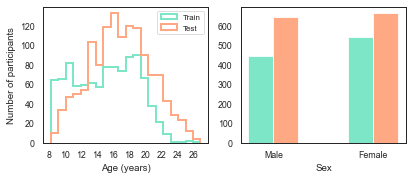

In [40]:
f, axes = plt.subplots(1,2)
f.set_figwidth(6.5)
f.set_figheight(2.5)
colormap = sns.color_palette("pastel", 2)

sns.distplot(df_out.loc[~df_out.loc[:,'train_test'],'scanageYears'], bins=20, hist=True, kde=False, rug=False, label = labels[0],
             hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1}, color=list(cmap[0]), ax = axes[0]);
sns.distplot(df_out.loc[df_out.loc[:,'train_test'],'scanageYears'], bins=20, hist=True, kde=False, rug=False, label = labels[1],
             hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1}, color=list(cmap[1]), ax = axes[0]);
axes[0].legend(prop={'size': 8});
axes[0].set_xlabel('Age (years)');
axes[0].set_ylabel('Number of participants');
axes[0].set_xticks(np.arange(np.min(np.round(age_unique,0)), np.max(np.round(age_unique,0)), 2))

# set width of bar
barWidth = 0.25

# Sex
y_train = [np.sum(df_out.loc[~df_out.loc[:,'train_test'],'sex'] == 1), np.sum(df_out.loc[~df_out.loc[:,'train_test'],'sex'] == 2)]
y_test = [np.sum(df_out.loc[df_out.loc[:,'train_test'],'sex'] == 1), np.sum(df_out.loc[df_out.loc[:,'train_test'],'sex'] == 2)]
r1 = np.arange(len(y_train))+barWidth/2
r2 = [x + barWidth for x in r1]
axes[1].bar(r1, y_train, width = barWidth, color = cmap[0], label = labels[0])
axes[1].bar(r2, y_test, width = barWidth, color = cmap[1], label = labels[1])
axes[1].set_xlabel('Sex')
axes[1].set_xticks([r + barWidth for r in range(len(y_train))])
axes[1].set_xticklabels(['Male', 'Female'])

f.savefig('age_distributions.svg', dpi = 150, bbox_inches = 'tight', pad_inches = 0)